# Loading the Data

In [156]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import (
    log_loss, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
import numpy as np
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in range(2012, 2025):
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2012.parquet from cached data
Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/2051513579.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,322450221037,32245022104,322450221,4,1,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,92,92,1,10,2,False,Rush,"Jamaine Cook rush for 2 yards to the YngSt 10,...",-0.207100,2,47
1,322450221048,32245022104,322450221,4,11,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,36,36,2,4,0,False,Rush,"Kurt Hess rush for no gain to the Pitt 36, tac...",-0.903926,15,0
2,322450221044,32245022104,322450221,4,7,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,1,10,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-1.138786,15,0
3,322450221045,32245022104,322450221,4,8,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,2,10,5,False,Pass Completion,Kurt Hess pass complete to Marcel Caver for 5 ...,0.068045,15,0
4,322450221041,32245022104,322450221,4,5,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,73,73,2,8,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-0.478808,2,47


In [7]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [8]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [9]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)

        tmp["start_time_minutes"] = tmp["start_time"].apply(lambda x: x["minutes"])
        tmp["start_time_seconds"] = tmp["start_time"].apply(lambda x: x["seconds"])
        tmp["end_time_minutes"] = tmp["end_time"].apply(lambda x: x["minutes"])
        tmp["end_time_seconds"] = tmp["end_time"].apply(lambda x: x["seconds"])
        tmp.drop(columns=["start_time","end_time"], inplace=True)

        season_drives = tmp.copy()
                
        season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(season_drives)
    
drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [10]:
game_team_stats_dir = join(DATA_DIR, 'game_team_stats')
if not os.path.exists(game_team_stats_dir):
    os.makedirs(game_team_stats_dir)

def flatten_team_data(row):
    game_id = row['id']
    teams_data = row['teams']
    
    # Parse the JSON string if it's not already parsed
    if isinstance(teams_data, str):
        teams_data = json.loads(teams_data)
    
    rows = []
    for team in teams_data:
        # Create base dictionary with non-stats fields
        team_row = {
            'game_id': game_id,
            'teamId': team['teamId'],
            'team': team['team'],
            'conference': team['conference'],
            'homeAway': team['homeAway'],
            'points': team['points']
        }
        
        # Add stats fields
        for stat in team['stats']:
            # Convert stat names to valid column names if needed
            col_name = stat['category']
            team_row[col_name] = stat['stat']
        
        rows.append(team_row)
    
    return rows

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'game_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        weeks = games.query('season == @year').week.unique().tolist()
        if not weeks:
            weeks = range(1, 16)

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} team stats data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.GamesApi(api_client)
                data = api_instance.get_game_team_stats(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                games_count = games.query('season == @year and week == @week and home_division == "fbs"').shape[0] + \
                    games.query('season == @year and week == @week and away_division == "fbs"').shape[0]
                print(f'No team stats data for {year} week {week}, number of FBS teams: {games_count}')
                continue

            flattened_data = []
            for _, row in tmp.iterrows():
                flattened_data.extend(flatten_team_data(row))
            result_df = pd.DataFrame(flattened_data)

            base_columns = ['game_id', 'teamId', 'team', 'conference', 'homeAway', 'points']
            stat_columns = [col for col in result_df.columns if col not in base_columns]
            result_df = result_df[base_columns + stat_columns]
            result_df.columns = convert_to_snake_case(result_df.columns)
            season_dfs.append(result_df)

        season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

        all_dfs.append(season_df)
        season_df.to_parquet(file_path)

team_stats = (
    games[['id', 'season', 'week', 'season_type']].rename(columns={'id': 'game_id'})
    .merge(
        pd.concat(all_dfs, ignore_index=True).reset_index(drop=True),
        on='game_id', how='left'
    )
    .dropna(subset=['team_id'])
    .sort_values(
        by=['season', 'season_type', 'week', 'team_id'], 
        ignore_index=True, 
        ascending=[True, False, True, True]
    )
)
team_stats.head()

Reading ../data/game_team_stats/2012.parquet from cached data
Reading ../data/game_team_stats/2013.parquet from cached data
Reading ../data/game_team_stats/2014.parquet from cached data
Reading ../data/game_team_stats/2015.parquet from cached data
Reading ../data/game_team_stats/2016.parquet from cached data
Reading ../data/game_team_stats/2017.parquet from cached data
Reading ../data/game_team_stats/2018.parquet from cached data
Reading ../data/game_team_stats/2019.parquet from cached data
Reading ../data/game_team_stats/2020.parquet from cached data
Reading ../data/game_team_stats/2021.parquet from cached data
Reading ../data/game_team_stats/2022.parquet from cached data
Reading ../data/game_team_stats/2023.parquet from cached data
Reading ../data/game_team_stats/2024.parquet from cached data


,game_id,season,week,season_type,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,passes_intercepted,interception_tds,interception_yards,kicking_points,kick_returns,kick_return_tds,kick_return_yards,passing_tds,punt_returns,punt_return_tds,punt_return_yards,rushing_tds,fumbles_recovered,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,322450002,2012,1,regular,2.0,Auburn,SEC,home,19.0,28:14,1,1,2,6-38,4.9,37,180,7.2,11-27,194,374,0-1,4-13,17,1,0,12,13,1,0,21,1,1,0,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322450005,2012,1,regular,5.0,UAB,Conference USA,home,29.0,41:39,1,3,4,9-47,3.0,44,134,9.6,19-34,325,459,0-2,8-16,23,None,None,None,5,5,0,82,2,3,0,-6,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322450006,2012,1,regular,6.0,South Alabama,Sun Belt,home,31.0,26:53,1,3,4,7-80,3.4,37,126,7.0,15-26,182,308,2-2,5-13,18,1,0,28,7,2,0,95,2,2,0,37,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322450008,2012,1,regular,8.0,Arkansas,SEC,home,49.0,25:41,0,3,3,6-38,4.7,35,164,11.8,23-34,400,564,0-2,5-9,25,None,None,None,7,4,0,96,3,5,0,29,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322430009,2012,1,regular,9.0,Arizona State,Pac-12,home,63.0,30:16,0,1,1,4-30,6.0,51,305,12.4,16-20,249,554,1-1,7-13,25,3,1,117,9,1,0,7,1,2,0,13,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
for season in team_stats.season.unique():
    n_row = team_stats.query('season == @season').shape[0]
    n_row_na_sacks = team_stats.query('season == @season and sacks.isna()').shape[0]
    pct_na_sacks = n_row_na_sacks / n_row * 100
    print(f'Season {season}: {n_row} rows, {n_row_na_sacks} rows with NA sacks ({pct_na_sacks:.2f}%)')

Season 2012: 1680 rows, 1680 rows with NA sacks (100.00%)
Season 2013: 1710 rows, 1710 rows with NA sacks (100.00%)
Season 2014: 1734 rows, 1734 rows with NA sacks (100.00%)
Season 2015: 1740 rows, 1740 rows with NA sacks (100.00%)
Season 2016: 1744 rows, 1 rows with NA sacks (0.06%)
Season 2017: 1748 rows, 11 rows with NA sacks (0.63%)
Season 2018: 1768 rows, 52 rows with NA sacks (2.94%)
Season 2019: 1776 rows, 0 rows with NA sacks (0.00%)
Season 2020: 1136 rows, 0 rows with NA sacks (0.00%)
Season 2021: 1774 rows, 0 rows with NA sacks (0.00%)
Season 2022: 3160 rows, 1393 rows with NA sacks (44.08%)
Season 2023: 3116 rows, 1334 rows with NA sacks (42.81%)
Season 2024: 3320 rows, 1493 rows with NA sacks (44.97%)


In [12]:
for season in team_stats.season.unique():
    n_row = team_stats.query('season == @season').shape[0]
    n_row_na_qb_hurry = team_stats.query('season == @season and qb_hurries.isna()').shape[0]
    pct_na_qb_hurries = n_row_na_qb_hurry / n_row * 100
    print(f'Season {season}: {n_row} rows, {n_row_na_qb_hurry} rows with NA QB hurries ({pct_na_qb_hurries:.2f}%)')

Season 2012: 1680 rows, 1680 rows with NA QB hurries (100.00%)
Season 2013: 1710 rows, 1710 rows with NA QB hurries (100.00%)
Season 2014: 1734 rows, 1734 rows with NA QB hurries (100.00%)
Season 2015: 1740 rows, 1740 rows with NA QB hurries (100.00%)
Season 2016: 1744 rows, 1 rows with NA QB hurries (0.06%)
Season 2017: 1748 rows, 11 rows with NA QB hurries (0.63%)
Season 2018: 1768 rows, 52 rows with NA QB hurries (2.94%)
Season 2019: 1776 rows, 0 rows with NA QB hurries (0.00%)
Season 2020: 1136 rows, 0 rows with NA QB hurries (0.00%)
Season 2021: 1774 rows, 0 rows with NA QB hurries (0.00%)
Season 2022: 3160 rows, 1393 rows with NA QB hurries (44.08%)
Season 2023: 3116 rows, 1334 rows with NA QB hurries (42.81%)
Season 2024: 3320 rows, 1493 rows with NA QB hurries (44.97%)


In [13]:
team_stats = (
    team_stats
    [['game_id', 'season', 'week', 'season_type', 'team_id', 'team', 'sacks', 'qb_hurries']]
    .query('season >= 2016')
    .assign(
        sacks = lambda x: x.sacks.fillna(0).astype(float),
        qb_hurries = lambda x: x.qb_hurries.fillna(0).astype(float)
    )
)

team_stats = (
    team_stats
    .rename(columns={
        'sacks': 'defense_sacks',
        'qb_hurries': 'defense_qb_hurries'
    })
    .merge(
        team_stats[['game_id','team_id','sacks','qb_hurries']]
            .rename(columns={
                'team_id': 'opponent_team_id',
                'sacks': 'offense_sacks_allowed',
                'qb_hurries': 'offense_qb_hurries_allowed'
            }),
        on=['game_id'], 
        how='left'
    )
    .query('team_id != opponent_team_id')
    .drop(columns=['opponent_team_id'])
    .reset_index(drop=True)
)

team_stats.head()

,game_id,season,week,season_type,team_id,team,defense_sacks,defense_qb_hurries,offense_sacks_allowed,offense_qb_hurries_allowed
0,400868971,2016,1,regular,2.0,Auburn,0.0,9.0,4.0,4.0
1,400868975,2016,1,regular,6.0,South Alabama,1.0,3.0,3.0,1.0
2,400868970,2016,1,regular,8.0,Arkansas,3.0,4.0,4.0,3.0
3,400869095,2016,1,regular,9.0,Arizona State,1.0,1.0,3.0,0.0
4,400868922,2016,1,regular,12.0,Arizona,1.0,0.0,4.0,0.0


In [14]:
team_stats = (
    team_stats
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last6 = (
    team_stats[[
        'team_id', 'defense_sacks', 'defense_qb_hurries', 
        'offense_sacks_allowed', 'offense_qb_hurries_allowed'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=6, min_periods=6)
    .sum()
)

rolling_stats_last6 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last6.rename(columns={
            'defense_sacks': 'last6_defense_sacks',
            'defense_qb_hurries': 'last6_defense_qb_hurries',
            'offense_sacks_allowed': 'last6_offense_sacks_allowed',
            'offense_qb_hurries_allowed': 'last6_offense_qb_hurries_allowed'
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last6_defense_sacks'])
    .query('season >= 2017')
    .reset_index(drop=True)
    .assign(
        last6_defense_sacks_per_game=lambda x: round(x.last6_defense_sacks / 6, 2),
        last6_defense_qb_hurries_per_game=lambda x: round(x.last6_defense_qb_hurries / 6, 2),
        last6_offense_sacks_allowed_per_game=lambda x: round(x.last6_offense_sacks_allowed / 6, 2),
        last6_offense_qb_hurries_allowed_per_game=lambda x: round(x.last6_offense_qb_hurries_allowed / 6, 2),
    )
    .drop(
        columns=[
            'last6_defense_sacks', 'last6_defense_qb_hurries', 
            'last6_offense_sacks_allowed', 'last6_offense_qb_hurries_allowed'
        ]
    )
)

rolling_stats_last6['last6_defense_sacks_per_game_gaussian'] = (
    rolling_stats_last6
    .groupby('team_id')['last6_defense_sacks_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last6['last6_defense_qb_hurries_per_game_gaussian'] = (
    rolling_stats_last6
    .groupby('team_id')['last6_defense_qb_hurries_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last6['last6_offense_sacks_allowed_per_game_gaussian'] = (
    rolling_stats_last6
    .groupby('team_id')['last6_offense_sacks_allowed_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last6['last6_offense_qb_hurries_allowed_per_game_gaussian'] = (
    rolling_stats_last6
    .groupby('team_id')['last6_offense_qb_hurries_allowed_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)

rolling_stats_last6.head()

,game_id,season,week,season_type,team_id,team,last6_defense_sacks_per_game,last6_defense_qb_hurries_per_game,last6_offense_sacks_allowed_per_game,last6_offense_qb_hurries_allowed_per_game,last6_defense_sacks_per_game_gaussian,last6_defense_qb_hurries_per_game_gaussian,last6_offense_sacks_allowed_per_game_gaussian,last6_offense_qb_hurries_allowed_per_game_gaussian
0,400933829,2017,1,regular,2.0,Auburn,1.17,4.50,0.67,2.83,1.170000,4.500000,0.670000,2.830000
1,400933843,2017,2,regular,2.0,Auburn,1.67,4.17,1.00,4.50,1.261213,4.439800,0.730200,3.134651
2,400933855,2017,3,regular,2.0,Auburn,2.17,3.17,2.83,4.67,1.421799,4.281756,0.952731,3.554466
3,400933868,2017,4,regular,2.0,Auburn,1.83,4.50,2.67,4.83,1.679221,4.015974,1.483652,4.131606
4,400933874,2017,5,regular,2.0,Auburn,1.83,3.17,2.83,4.00,1.891856,3.811459,2.226344,4.530791


In [15]:
team_stats = (
    team_stats
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last12 = (
    team_stats[[
        'team_id', 'defense_sacks', 'defense_qb_hurries', 
        'offense_sacks_allowed', 'offense_qb_hurries_allowed'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=12, min_periods=12)
    .sum()
)

rolling_stats_last12 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last12.rename(columns={
            'defense_sacks': 'last12_defense_sacks',
            'defense_qb_hurries': 'last12_defense_qb_hurries',
            'offense_sacks_allowed': 'last12_offense_sacks_allowed',
            'offense_qb_hurries_allowed': 'last12_offense_qb_hurries_allowed'
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last12_defense_sacks'])
    .query('season >= 2017')
    .reset_index(drop=True)
    .assign(
        last12_defense_sacks_per_game=lambda x: round(x.last12_defense_sacks / 12, 2),
        last12_defense_qb_hurries_per_game=lambda x: round(x.last12_defense_qb_hurries / 12, 2),
        last12_offense_sacks_allowed_per_game=lambda x: round(x.last12_offense_sacks_allowed / 12, 2),
        last12_offense_qb_hurries_allowed_per_game=lambda x: round(x.last12_offense_qb_hurries_allowed / 12, 2),
    )
    .drop(
        columns=[
            'last12_defense_sacks', 'last12_defense_qb_hurries', 
            'last12_offense_sacks_allowed', 'last12_offense_qb_hurries_allowed'
        ]
    )
)

rolling_stats_last12['last12_defense_sacks_per_game_gaussian'] = (
    rolling_stats_last12
    .groupby('team_id')['last12_defense_sacks_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last12['last12_defense_qb_hurries_per_game_gaussian'] = (
    rolling_stats_last12
    .groupby('team_id')['last12_defense_qb_hurries_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last12['last12_offense_sacks_allowed_per_game_gaussian'] = (
    rolling_stats_last12
    .groupby('team_id')['last12_offense_sacks_allowed_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)
rolling_stats_last12['last12_offense_qb_hurries_allowed_per_game_gaussian'] = (
    rolling_stats_last12
    .groupby('team_id')['last12_offense_qb_hurries_allowed_per_game']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)

rolling_stats_last12.head()

,game_id,season,week,season_type,team_id,team,last12_defense_sacks_per_game,last12_defense_qb_hurries_per_game,last12_offense_sacks_allowed_per_game,last12_offense_qb_hurries_allowed_per_game,last12_defense_sacks_per_game_gaussian,last12_defense_qb_hurries_per_game_gaussian,last12_offense_sacks_allowed_per_game_gaussian,last12_offense_qb_hurries_allowed_per_game_gaussian
0,400933829,2017,1,regular,2.0,Auburn,2.08,6.42,1.25,2.92,2.080000,6.420000,1.250000,2.920000
1,400933843,2017,2,regular,2.0,Auburn,2.17,6.42,1.42,3.58,2.096418,6.420000,1.281012,3.040401
2,400933855,2017,3,regular,2.0,Auburn,2.42,5.42,2.00,3.42,2.137755,6.342304,1.367467,3.188665
3,400933868,2017,4,regular,2.0,Auburn,2.08,5.50,1.83,3.00,2.206137,6.108707,1.549520,3.334790
4,400933874,2017,5,regular,2.0,Auburn,2.08,5.00,1.83,2.92,2.238869,5.715341,1.766719,3.302019


### Note: switching training data date range to be 2017-2024 (2016 for rolling avg), as the sack data started being tracked in 2016

# Data Engineering

In [36]:
sack_attempts = (
    plays    
    .assign(play_text=plays.play_text.fillna('')
        .str.replace(',', '', regex=False)
        .str.replace('.', '', regex=False)
        .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
)
sure_pass_plays = [
    'Pass Completion', 'Pass Incompletion', 'Pass Interception', 'Sack', 'Pass',
    'Passing Touchdown', 'Pass Reception', 'Pass Interception Return', 
    'Interception Return Touchdown', 'Interception',
]
potential_pass_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
pass_condition = (
    sack_attempts['play_type'].isin(sure_pass_plays) |
    (
        sack_attempts['play_type'].isin(potential_pass_plays) &
        ~sack_attempts['play_text'].str.contains(" run ") &
        ~sack_attempts['play_text'].str.contains(" rush ") &
        ~sack_attempts['play_text'].str.contains(" kneel ") &
        ~sack_attempts['play_text'].str.contains(" kneeling ") &
        ~sack_attempts['play_text'].str.contains(" kneels ") &
        (        
            sack_attempts['play_text'].str.contains(" pass ") |
            sack_attempts['play_text'].str.contains(" sack ") |
            sack_attempts['play_text'].str.contains(" sacked ") |
            sack_attempts['play_text'].str.contains(" intercepted ") |
            sack_attempts['play_text'].str.contains(" interception ") |
            sack_attempts['play_text'].str.contains(" intentional grounding ") |
            sack_attempts['play_text'].str.contains(" scramble ") 
        )
    )
)

sack_attempts = (
    sack_attempts[pass_condition]
    # dropping all penalty plays, difficult to parse penalty outcomes
    .query('~play_text.str.contains(" penalty ")')
    .merge(
        games[['id', 'season']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .query('season >= 2017')  # Filter out seasons before 2017 (sack data starts 2016, but need 1 year for rolling stats)
    .drop(columns=['season'])
    .query(
        'down.isin([1,2,3,4]) and '
        'period.isin([1, 2, 3, 4])'
    )
    .assign(
        was_sack = lambda x: np.where(
            (x.play_type == 'Sack') |
            x.play_text.str.contains(" sack ") |
            x.play_text.str.contains(" sacked "),
            1, 0
        )
    )
    .assign(
        sack_fumble = lambda x: np.where(
            (x.play_text.str.contains(" fumble ") |
             x.play_text.str.contains(" fumbled ")) &
            (x.was_sack == 1),
            1, 0
        ),
    )
    .reset_index(drop=True)
)

sack_attempts.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,was_sack,sack_fumble
0,400944827104949601,40094482729,400944827,29,1,Idaho,Sun Belt,28,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,35,65,1,10,17,False,Pass Reception,matt linehan pass complete to jacob sannon fo...,1.556483,5,3,0,0
1,400944827104979106,40094482729,400944827,29,9,Idaho,Sun Belt,28,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,0.0,3.0,66,34,4,15,9,False,Pass Reception,matt linehan pass complete to jacob sannon fo...,-0.966674,2,8,0,0
2,400944827103949802,40094482721,400944827,21,1,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,3,2.0,3.0,20,80,1,10,0,False,Pass Interception Return,matt linehan pass intercepted mister harriel ...,-0.613942,5,1,0,0
3,400944827104899209,40094482727,400944827,27,2,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,56,44,2,9,4,False,Pass Reception,matt linehan pass complete to reuben mwehla f...,-0.154569,10,7,0,0
4,400944827104899210,40094482727,400944827,27,3,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,60,40,3,5,5,False,Pass Reception,matt linehan pass complete to reuben mwehla f...,1.429455,10,7,0,0


In [37]:
sack_attempts = (
    sack_attempts
    .assign(
        sack_yards_lost = lambda x: np.where(
            x.was_sack == 1,
            np.where(
                x.play_text.str.extract(r'for a loss of (\d+) yard')[0].notnull(),
                x.play_text.str.extract(r'for a loss of (\d+) yard')[0].astype(float),
                np.where(
                    x.play_text.str.extract(r'for -(\d+) yard')[0].notnull(),
                    x.play_text.str.extract(r'for -(\d+) yard')[0].astype(float),
                    np.where(
                        x.play_text.str.contains(' for 0 yards '),
                        0.0,
                        np.where(
                            x.play_text.str.extract(r'for -(\d+) yds ')[0].notnull(),
                            x.play_text.str.extract(r'for -(\d+) yds ')[0].astype(float),
                            np.where(
                                x.play_text.str.extract(r'for -(\d+) ydsa ')[0].notnull(),
                                x.play_text.str.extract(r'for -(\d+) ydsa ')[0].astype(float),
                                np.where(
                                    x.play_text.str.extract(r'for (\d+) yards ')[0].notnull(),
                                    x.play_text.str.extract(r'for (\d+) yards ')[0].astype(float),
                                    np.where(
                                        x.play_text.str.extract(r'for (\d+) yds ')[0].notnull(),
                                        x.play_text.str.extract(r'for (\d+) yds ')[0].astype(float),
                                        np.where(
                                            x.play_text.str.extract(r'for loss of (\d+) yard')[0].notnull(),
                                            x.play_text.str.extract(r'for loss of (\d+) yard')[0].astype(float),
                                            np.where(
                                                x.play_text.str.extract(r'for loss of (\d+) yds ')[0].notnull(),
                                                x.play_text.str.extract(r'for loss of (\d+) yds ')[0].astype(float),
                                                np.nan
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            ),
            np.nan
        ),
        sack_fumble_recovery_team = lambda x: np.where(
            x.sack_fumble == 1,
            np.where(
                (x.play_type == "Fumble Recovery (Own)") | (x.play_text.str.contains(" safety ")),
                "offense", # offense recovery or safety
                "defense" # defense recovery or touchdown recovery
            ),
            np.nan
        ),
        sack_fumble_recovery_yards = lambda x: np.where(
            x.sack_fumble == 1,
            np.where(
                x.play_text.str.extract(r' return for (\d+) yard')[0].notnull(),
                x.play_text.str.extract(r' return for (\d+) yard')[0].astype(float),
                np.where(
                    x.play_text.str.extract(r' return for (\d+) yd')[0].notnull(),
                    x.play_text.str.extract(r' return for (\d+) yd')[0].astype(float),
                    np.where(
                        x.play_text.str.extract(r' (\d+) yd fumble return')[0].notnull(),
                        x.play_text.str.extract(r' (\d+) yd fumble return')[0].astype(float),
                        np.where(
                            x.play_text.str.extract(r' (\d+) yard fumble return')[0].notnull(),
                            x.play_text.str.extract(r' (\d+) yard fumble return')[0].astype(float),
                            np.where(
                                x.play_text.str.extract(r' return for -(\d+) yard')[0].notnull(),
                                -x.play_text.str.extract(r' return for -(\d+) yard')[0].astype(float),
                                np.where(
                                    x.play_text.str.extract(r' return for -(\d+) yds ')[0].notnull(),
                                    -x.play_text.str.extract(r' return for -(\d+) yds ')[0].astype(float),
                                    np.where(
                                        x.play_text.str.extract(r' returned (\d+) yards ')[0].notnull(),
                                        x.play_text.str.extract(r' returned (\d+) yards ')[0].astype(float),
                                        np.where(
                                            x.play_text.str.extract(r' returned (\d+) yds ')[0].notnull(),
                                            x.play_text.str.extract(r' returned (\d+) yds ')[0].astype(float),
                                            np.where(
                                                x.play_text.str.extract(r' return (\d+) yard')[0].notnull(),
                                                x.play_text.str.extract(r' return (\d+) yard')[0].astype(float),
                                                np.where(
                                                    x.play_text.str.extract(r' return (\d+) yd')[0].notnull(),
                                                    x.play_text.str.extract(r' return (\d+) yd')[0].astype(float),
                                                    0.0
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            ),
            np.nan
        )
    )
    .query('sack_yards_lost.isna() or sack_yards_lost <= 20') # Filter out unrealistic sack yardage
    .query('(was_sack==1 and sack_yards_lost.notnull()) | was_sack==0') # all sacks must have yardage lost value
)

sack_attempts.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,was_sack,sack_fumble,sack_yards_lost,sack_fumble_recovery_team,sack_fumble_recovery_yards
0,400944827104949601,40094482729,400944827,29,1,Idaho,Sun Belt,28,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,35,65,1,10,17,False,Pass Reception,matt linehan pass complete to jacob sannon fo...,1.556483,5,3,0,0,NaN,nan,NaN
1,400944827104979106,40094482729,400944827,29,9,Idaho,Sun Belt,28,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,0.0,3.0,66,34,4,15,9,False,Pass Reception,matt linehan pass complete to jacob sannon fo...,-0.966674,2,8,0,0,NaN,nan,NaN
2,400944827103949802,40094482721,400944827,21,1,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,3,2.0,3.0,20,80,1,10,0,False,Pass Interception Return,matt linehan pass intercepted mister harriel ...,-0.613942,5,1,0,0,NaN,nan,NaN
3,400944827104899209,40094482727,400944827,27,2,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,56,44,2,9,4,False,Pass Reception,matt linehan pass complete to reuben mwehla f...,-0.154569,10,7,0,0,NaN,nan,NaN
4,400944827104899210,40094482727,400944827,27,3,Idaho,Sun Belt,21,Sacramento State,Idaho,Sacramento State,Big Sky,6,4,1.0,3.0,60,40,3,5,5,False,Pass Reception,matt linehan pass complete to reuben mwehla f...,1.429455,10,7,0,0,NaN,nan,NaN


In [38]:
# Key Finding: plays where the play_text contains fumble and the play_type is "Sack" are recovered by defense
# When the the play_text is "Fumble Recovery (Own)", it means the offense recovered the fumble

sack_attempts.query('sack_fumble == 1')[['offense','defense','play_type','play_text']].values[:10]

array([['Idaho', 'Sacramento State', 'Fumble Recovery (Own)',
        ' matt linehan sacked by george obinna for a loss of 11 yards to the idaho 25 matt linehan fumbled recovered by idaho jacob sannon  return for 0 yards '],
       ['Idaho', 'Sacramento State', 'Sack',
        ' matt linehan sacked by george obinna for a loss of 5 yards to the idaho 6 matt linehan fumbled recovered by sacst seperini aumua  return for 0 yards '],
       ['Middle Tennessee', 'Vanderbilt', 'Fumble Recovery (Own)',
        ' brent stockstill sacked by dare odeyingbo for a loss of 8 yards to the vandy 36 brent stockstill fumbled recovered by mtnst shane tucker  return for 0 yards  return for 16 yds to the vandy 36 '],
       ['North Texas', 'Troy', 'Sack',
        ' mason fine sacked by tyler murray for a loss of 20 yards to the notex 13 mason fine fumbled forced by tyler murray recovered by troy '],
       ['North Texas', 'Troy', 'Fumble Recovery (Own)',
        ' mason fine sacked by sam lebbie for a loss

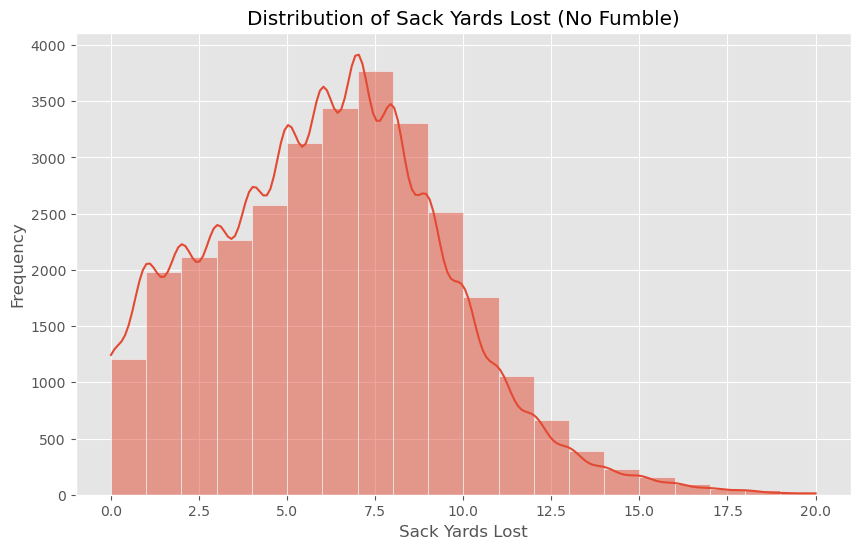

In [39]:
# Distrubution of sack yards lost when there was no fumble
plt.style.use('ggplot')
qry = sack_attempts.query('was_sack == 1 and sack_fumble == 0')
plt.figure(figsize=(10, 6))
sns.histplot(qry['sack_yards_lost'], bins=20, kde=True)
plt.title('Distribution of Sack Yards Lost (No Fumble)')
plt.xlabel('Sack Yards Lost')
plt.ylabel('Frequency')
plt.show() 

In [40]:
id_cols = ['season', 'week', 'play_id', 'drive_id', 'game_id', 'drive_number', 
           'play_number', 'offense', 'defense', 'play_type','play_text']
features = [
    'offense_timeouts', 'defense_timeouts','yards_to_goal','score_diff',
    'down', 'distance',
    'pct_game_played', 'diff_time_ratio', 
    'is_home_team', 'grass',
    'elevation', 'offense_elo', 'defense_elo', 'elo_diff',
    'temperature', 'wind_speed', 'precipitation',
    'last12_offense_sacks_allowed_per_game',
    'last12_offense_qb_hurries_allowed_per_game',
    'last12_offense_sacks_allowed_per_game_gaussian',
    'last12_offense_qb_hurries_allowed_per_game_gaussian',
    'last12_defense_sacks_per_game',
    'last12_defense_qb_hurries_per_game',
    'last12_defense_sacks_per_game_gaussian',
    'last12_defense_qb_hurries_per_game_gaussian',
    'last6_offense_sacks_allowed_per_game',
    'last6_offense_qb_hurries_allowed_per_game',
    'last6_offense_sacks_allowed_per_game_gaussian',
    'last6_offense_qb_hurries_allowed_per_game_gaussian', 
    'last6_defense_sacks_per_game',
    'last6_defense_qb_hurries_per_game',
    'last6_defense_sacks_per_game_gaussian',
    'last6_defense_qb_hurries_per_game_gaussian'
]
outcome_cols =['was_sack', 'sack_fumble',
       'sack_yards_lost', 'sack_fumble_recovery_team',
       'sack_fumble_recovery_yards']

sack_attempts = (
    sack_attempts
    .rename(columns={'id': 'play_id'})
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts),
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
    )
    .merge(
        games[['id','season','week','venue_id','home_team','neutral_site']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        venues[['id','elevation','grass']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense'],
        right_on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense'],
        right_on=['season', 'week', 'defense'],
        how='left'
    )
    .assign(
        elo_diff=lambda x: x.offense_elo - x.defense_elo,
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .assign(
        wind_speed=lambda x: np.where(
            x.game_indoors, 0, x.wind_speed.fillna(int(x.wind_speed.mean()))
        ),
        precipitation=lambda x: np.where(
            x.game_indoors, 0, x.precipitation.fillna(int(x.precipitation.mean()))
        ),
        temperature=lambda x: np.where(
            x.game_indoors, 70, x.temperature.fillna(int(x.temperature.mean()))
        ),
        grass = lambda x: x.grass.fillna(False).astype(int),
        is_home_team=lambda x: np.where(
            x.neutral_site, 0, np.where(x.offense == x.home_team, 1, -1)
        ),
    )
    .merge(
        rolling_stats_last12[[
            'game_id', 'team',
            'last12_offense_sacks_allowed_per_game',
            'last12_offense_qb_hurries_allowed_per_game',
            'last12_offense_sacks_allowed_per_game_gaussian',
            'last12_offense_qb_hurries_allowed_per_game_gaussian'
        ]].rename(columns={
            'team': 'offense'
        }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last12[[
            'game_id', 'team',
            'last12_defense_sacks_per_game', 
            'last12_defense_qb_hurries_per_game',
            'last12_defense_sacks_per_game_gaussian',
            'last12_defense_qb_hurries_per_game_gaussian',
        ]].rename(columns={
            'team': 'defense'
        }),
        on=['game_id', 'defense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[[
            'game_id', 'team',
            'last6_offense_sacks_allowed_per_game',
            'last6_offense_qb_hurries_allowed_per_game',
            'last6_offense_sacks_allowed_per_game_gaussian',
            'last6_offense_qb_hurries_allowed_per_game_gaussian'
        ]].rename(columns={
            'team': 'offense'
        }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[[
            'game_id', 'team',
            'last6_defense_sacks_per_game', 
            'last6_defense_qb_hurries_per_game',
            'last6_defense_sacks_per_game_gaussian',
            'last6_defense_qb_hurries_per_game_gaussian',
        ]].rename(columns={
            'team': 'defense'
        }),
        on=['game_id', 'defense'],
        how='left'
    )
    # .dropna(
    #     subset=[
    #         'last12_offense_sacks_allowed_per_game',
    #         'last6_offense_sacks_allowed_per_game',
    #     ]
    # )
    [id_cols + features + outcome_cols]
)
sack_attempts['elevation'] = (
    sack_attempts['elevation']
    .fillna(int(sack_attempts.elevation.astype(float).mean()))
    .astype(float)  
)
sack_attempts.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/1662984392.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = lambda x: x.grass.fillna(False).astype(int),


,season,week,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,down,distance,pct_game_played,diff_time_ratio,is_home_team,grass,elevation,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,last12_offense_sacks_allowed_per_game,last12_offense_qb_hurries_allowed_per_game,last12_offense_sacks_allowed_per_game_gaussian,last12_offense_qb_hurries_allowed_per_game_gaussian,last12_defense_sacks_per_game,last12_defense_qb_hurries_per_game,last12_defense_sacks_per_game_gaussian,last12_defense_qb_hurries_per_game_gaussian,last6_offense_sacks_allowed_per_game,last6_offense_qb_hurries_allowed_per_game,last6_offense_sacks_allowed_per_game_gaussian,last6_offense_qb_hurries_allowed_per_game_gaussian,last6_defense_sacks_per_game,last6_defense_qb_hurries_per_game,last6_defense_sacks_per_game_gaussian,last6_defense_qb_hurries_per_game_gaussian,was_sack,sack_fumble,sack_yards_lost,sack_fumble_recovery_team,sack_fumble_recovery_yards
0,2017,1,400944827104949601,40094482729,400944827,29,1,Idaho,Sacramento State,Pass Reception,matt linehan pass complete to jacob sannon fo...,1.0,3.0,65,22,1,10,0.915833,857.804130,1,0,794.479492,1451.432627,857.245793,594.186834,70.0,0.0,0.0,2.04,1.08,2.04,1.08,NaN,NaN,NaN,NaN,2.08,1.0,2.08,1.0,NaN,NaN,NaN,NaN,0,0,NaN,nan,NaN
1,2017,1,400944827104979106,40094482729,400944827,29,9,Idaho,Sacramento State,Pass Reception,matt linehan pass complete to jacob sannon fo...,0.0,3.0,34,22,4,15,0.964444,1041.919778,1,0,794.479492,1451.432627,857.245793,594.186834,70.0,0.0,0.0,2.04,1.08,2.04,1.08,NaN,NaN,NaN,NaN,2.08,1.0,2.08,1.0,NaN,NaN,NaN,NaN,0,0,NaN,nan,NaN
2,2017,1,400944827103949802,40094482721,400944827,21,1,Idaho,Sacramento State,Pass Interception Return,matt linehan pass intercepted mister harriel ...,2.0,3.0,80,15,1,10,0.666389,215.639009,1,0,794.479492,1451.432627,857.245793,594.186834,70.0,0.0,0.0,2.04,1.08,2.04,1.08,NaN,NaN,NaN,NaN,2.08,1.0,2.08,1.0,NaN,NaN,NaN,NaN,0,0,NaN,nan,NaN
3,2017,1,400944827104899209,40094482727,400944827,27,2,Idaho,Sacramento State,Pass Reception,matt linehan pass complete to reuben mwehla f...,1.0,3.0,44,15,2,9,0.831389,417.216702,1,0,794.479492,1451.432627,857.245793,594.186834,70.0,0.0,0.0,2.04,1.08,2.04,1.08,NaN,NaN,NaN,NaN,2.08,1.0,2.08,1.0,NaN,NaN,NaN,NaN,0,0,NaN,nan,NaN
4,2017,1,400944827104899210,40094482727,400944827,27,3,Idaho,Sacramento State,Pass Reception,matt linehan pass complete to reuben mwehla f...,1.0,3.0,40,15,3,5,0.831389,417.216702,1,0,794.479492,1451.432627,857.245793,594.186834,70.0,0.0,0.0,2.04,1.08,2.04,1.08,NaN,NaN,NaN,NaN,2.08,1.0,2.08,1.0,NaN,NaN,NaN,NaN,0,0,NaN,nan,NaN


# Model 1: Sack Model

In [93]:
feature_names = [
    'yards_to_goal',
    # 'score_diff',
    'down',
    'distance',
    # 'pct_game_played',
    'diff_time_ratio',
    # 'is_home_team',
    # 'grass',
    # 'elevation',
    # 'offense_elo',
    # 'defense_elo',
    'elo_diff',
    # 'temperature',
    # 'wind_speed',
    # 'precipitation',
    # 'last12_offense_sacks_allowed_per_game',
    # 'last12_offense_qb_hurries_allowed_per_game',
    # 'last12_offense_sacks_allowed_per_game_gaussian',
    # 'last12_offense_qb_hurries_allowed_per_game_gaussian',
    # 'last12_defense_sacks_per_game',
    # 'last12_defense_qb_hurries_per_game',
    # 'last12_defense_sacks_per_game_gaussian',
    # 'last12_defense_qb_hurries_per_game_gaussian',
    'last6_offense_sacks_allowed_per_game',
    # 'last6_offense_qb_hurries_allowed_per_game',
    # 'last6_offense_sacks_allowed_per_game_gaussian',
    # 'last6_offense_qb_hurries_allowed_per_game_gaussian',
    'last6_defense_sacks_per_game',
    # 'last6_defense_qb_hurries_per_game',
    # 'last6_defense_sacks_per_game_gaussian',
    # 'last6_defense_qb_hurries_per_game_gaussian',
    ]

target_variable = 'was_sack'

data = sack_attempts[feature_names + [target_variable]].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data[target_variable]
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data[target_variable]
)

In [94]:
train_y.value_counts(normalize=True)

was_sack
0    0.939292
1    0.060708
Name: proportion, dtype: float64

In [95]:
valid_y.value_counts(normalize=True)

was_sack
0    0.939298
1    0.060702
Name: proportion, dtype: float64

In [96]:
test_y.value_counts(normalize=True)

was_sack
0    0.939289
1    0.060711
Name: proportion, dtype: float64

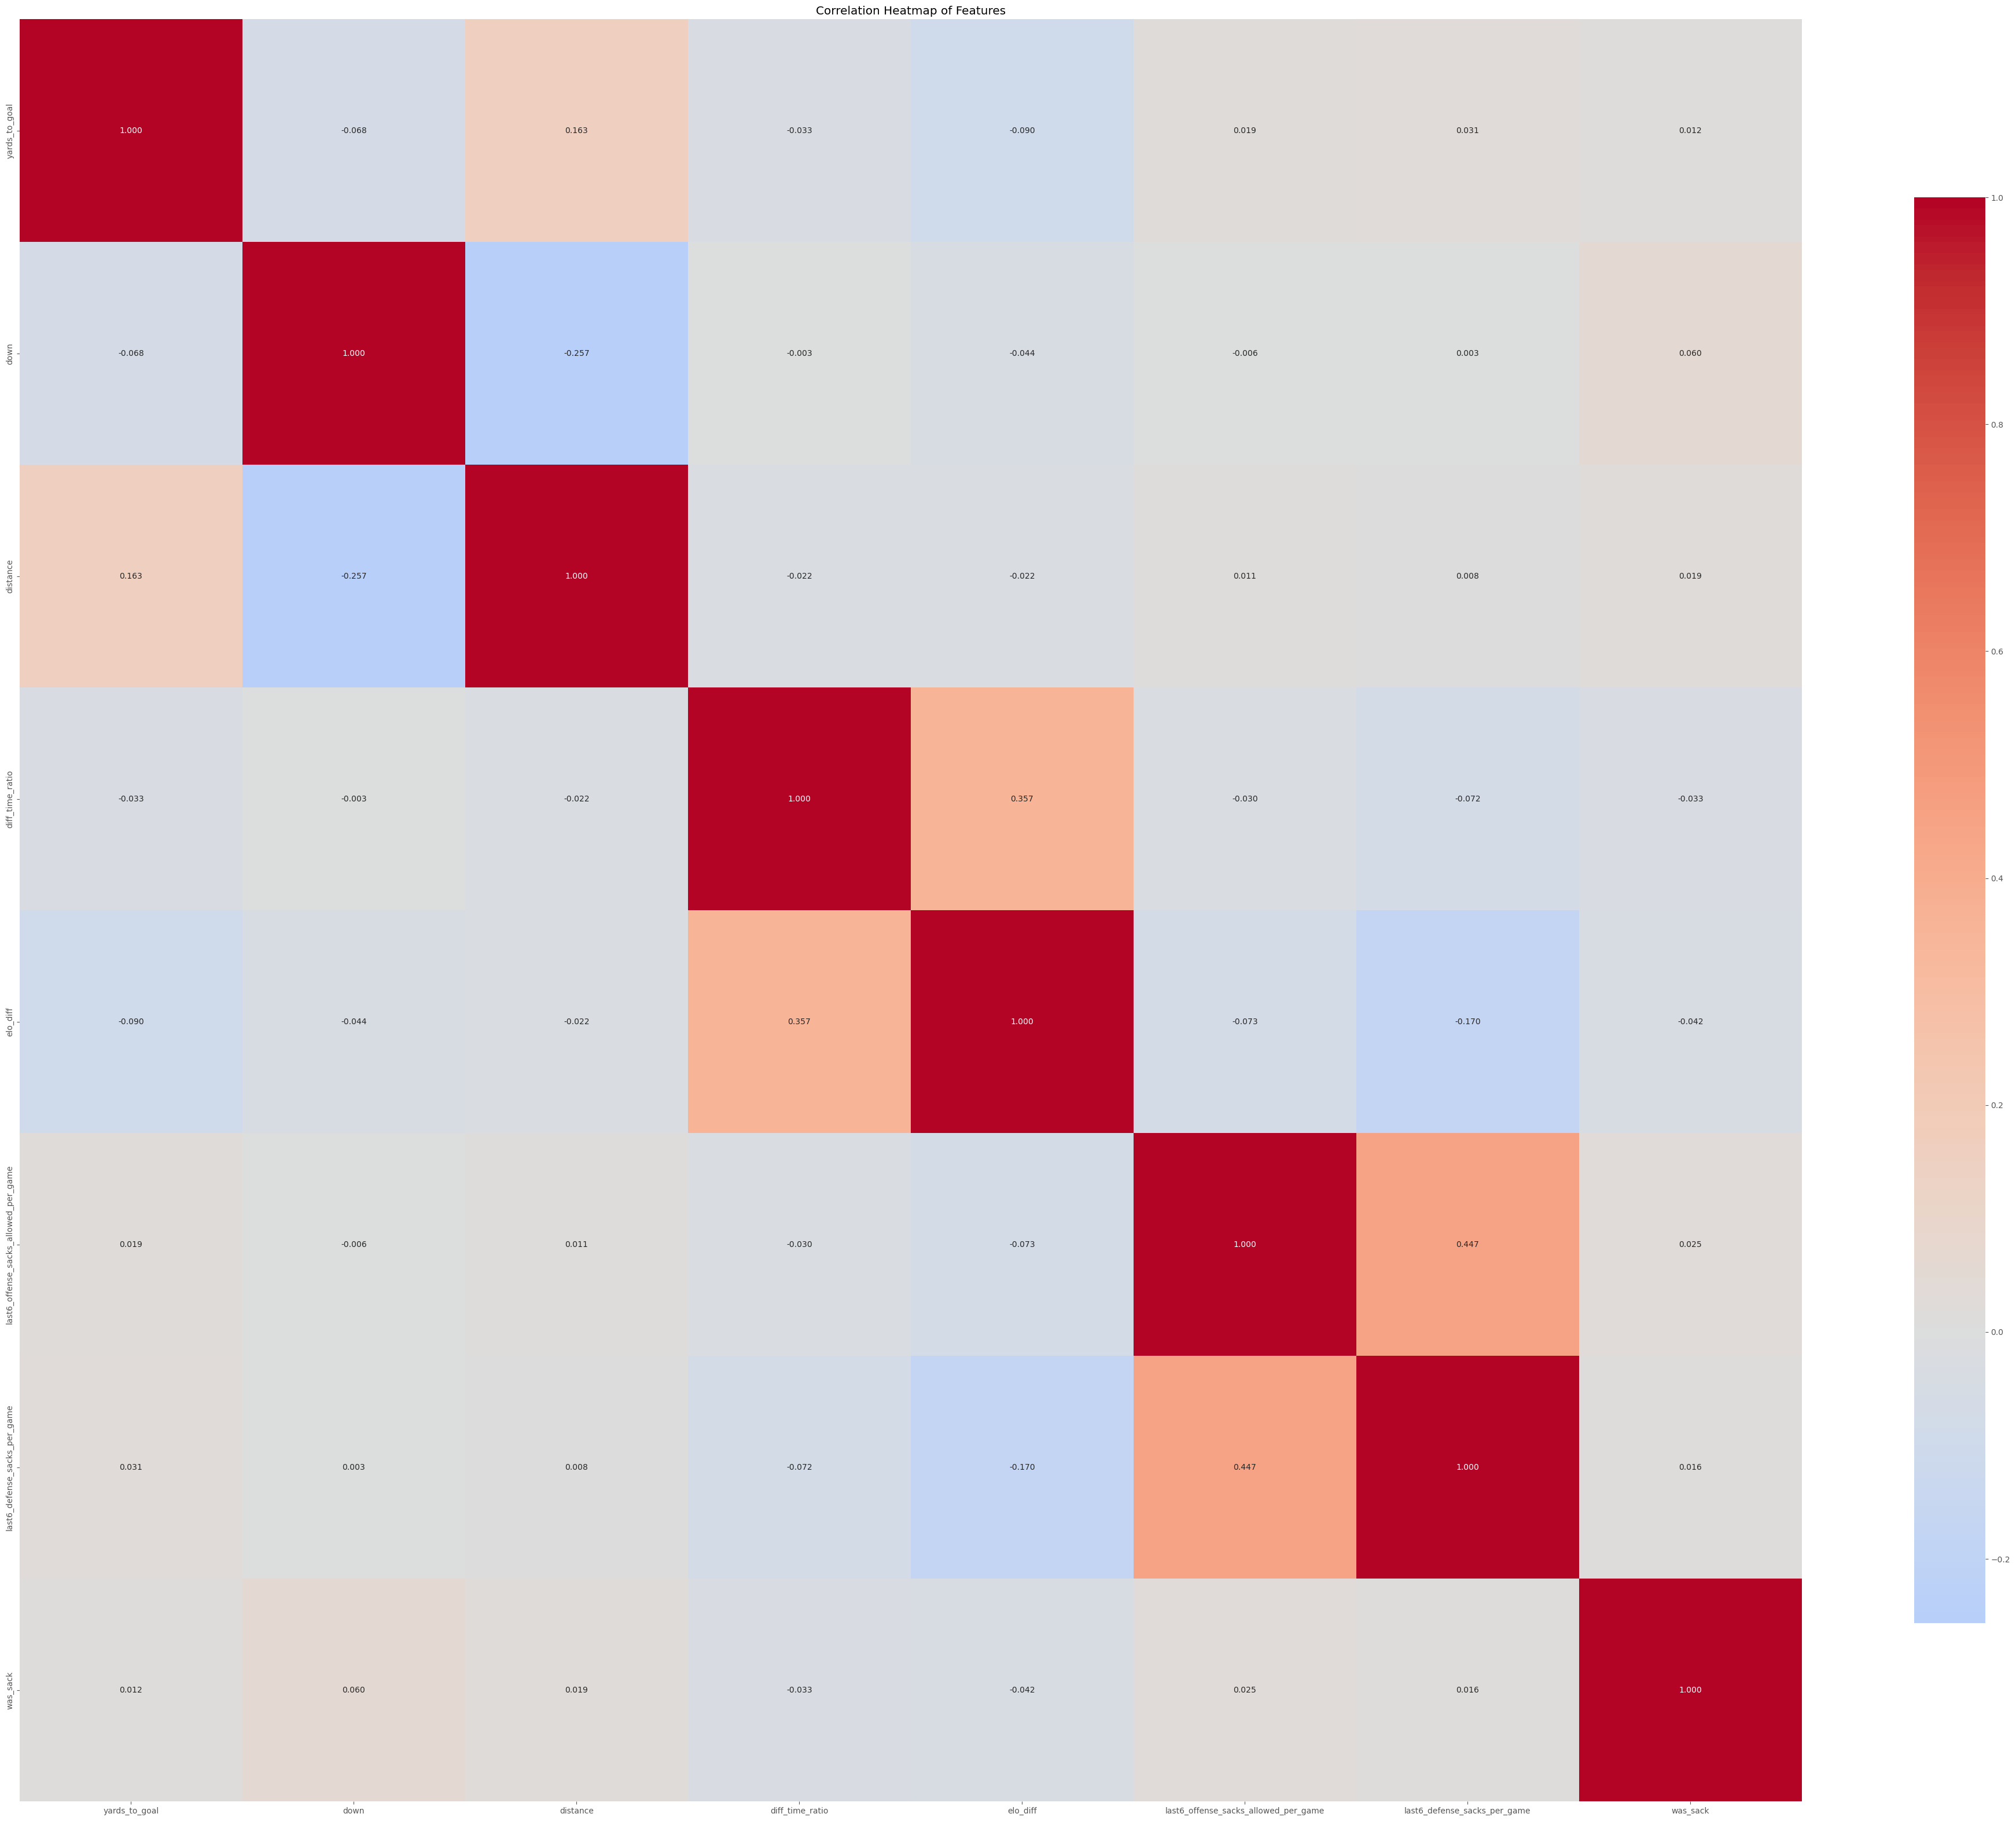

In [97]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    sack_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [98]:
# from sklearn.utils.class_weight import compute_sample_weight
# train_sample_weights = compute_sample_weight(class_weight='balanced', y=train_y)
# valid_sample_weights = compute_sample_weight(class_weight='balanced', y=valid_y)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

monotonic_constraints_map = {
    'yards_to_goal': -1, # redzone is condensed field, more likely to hold ball w/o open receivers
    'down': 1, # later in down, sack more likely as qb may hold the ball longer
    'distance': 1, # longer distance, more likely to hold the ball
    'diff_time_ratio': -1, # losing team more likely to hold the ball
    'elo_diff': -1, # less talented team more likely to be sacked
    'last6_offense_sacks_allowed_per_game': 1, # more sacks allowed, more likely to be sacked
    'last6_defense_sacks_per_game': 1, # more sacks by defense, more likely to be sacked
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "monotone_constraints": monotonic_constraints,
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y) #, weight=train_sample_weights)
dvalid = xgb.DMatrix(valid_x, label=valid_y) #, weight=valid_sample_weights)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="blocked_fg_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'monotone_constraints': monotonic_constraints,
    'nthread': -1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 83


In [99]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, log_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = np.where(y_proba > 0.5, 1, 0)

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")

# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9393
Macro F1 Score    : 0.4843
Log Loss          : 0.2236

=== VALIDATION SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9393
Macro F1 Score    : 0.4843
Log Loss          : 0.2244

=== TEST SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9393
Macro F1 Score    : 0.4843
Log Loss          : 0.2237


In [101]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = balanced_accuracy_score(test_y, dummy.predict(test_x))
dummy_acc = accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Accuracy          : {dummy_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9393
Macro F1 Score    : 0.4843
Log Loss          : 0.2289


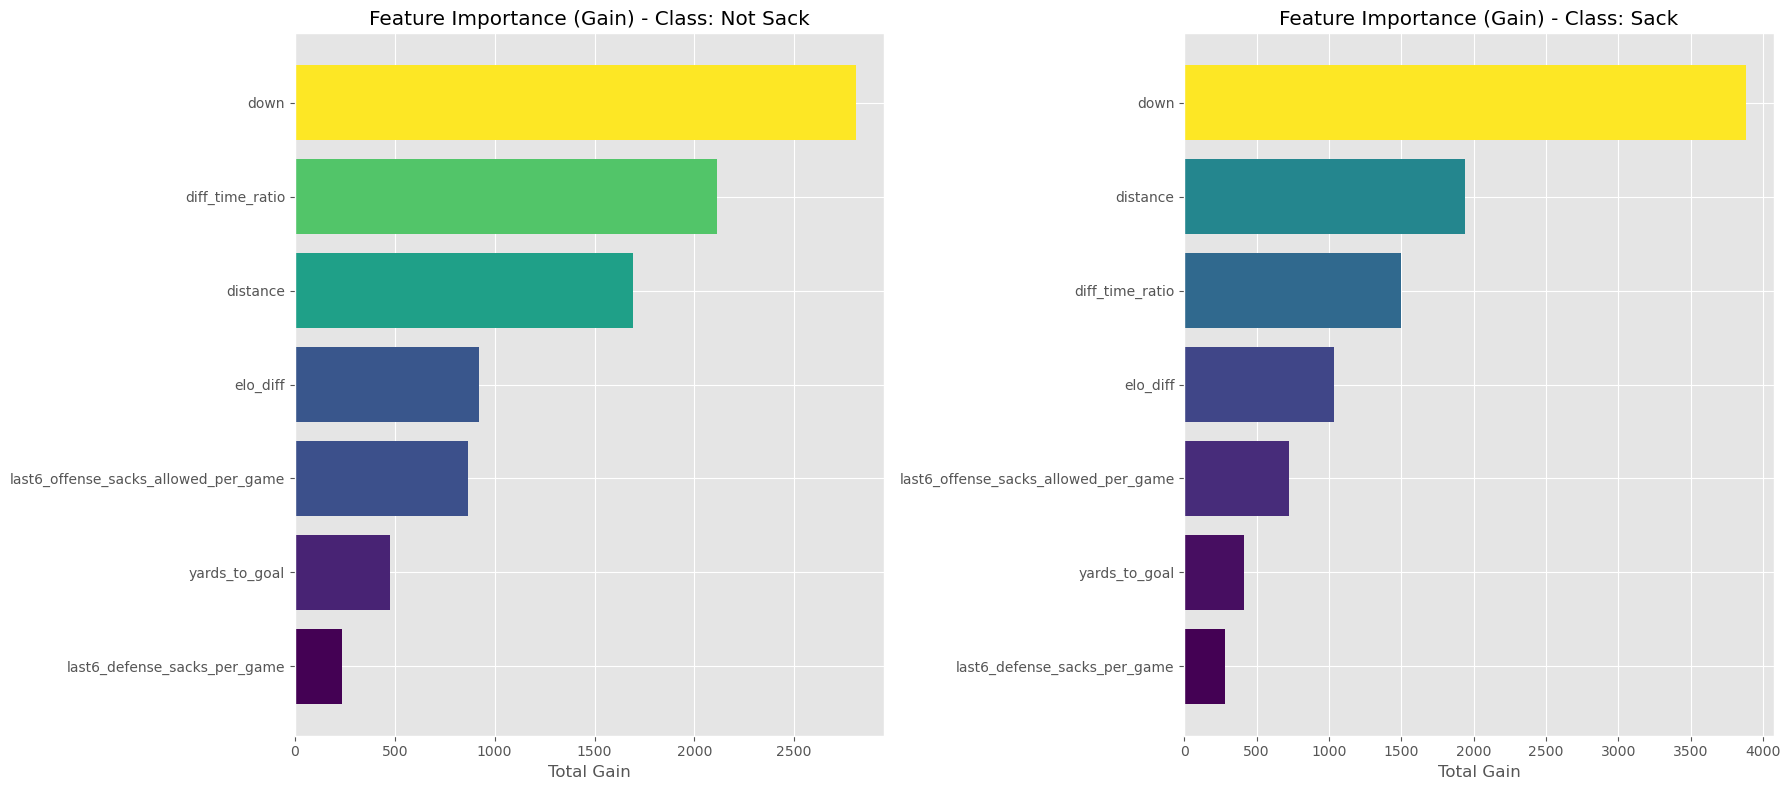

In [102]:
import matplotlib.cm as cm

num_classes = 2
class_names = ['Not Sack', 'Sack']
trees_df = final_model.trees_to_dataframe()

fig, axes = plt.subplots(1,2, figsize=(18, 8))
axes = axes.flatten()

for class_id in range(num_classes):
    class_trees = trees_df[trees_df['Tree'] % num_classes == class_id]
    class_gain = (
        class_trees[class_trees['Feature'] != 'Leaf']
        .groupby('Feature')['Gain']
        .sum()
        .sort_values(ascending=False)
    )
    top_features = class_gain[:20]
    norm = plt.Normalize(top_features.min(), top_features.max())
    colors = cm.viridis(norm(top_features.values))

    ax = axes[class_id]
    ax.barh(top_features.index, top_features.values, color=colors)
    ax.set_title(f"Feature Importance (Gain) - Class: {class_names[class_id]}")
    ax.invert_yaxis()
    ax.set_xlabel("Total Gain")

plt.tight_layout()
plt.show()


100%|██████████| 10/10 [00:01<00:00,  8.39it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


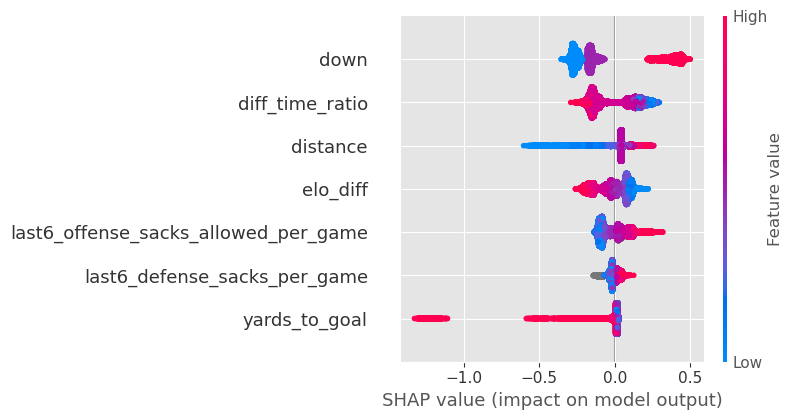

In [103]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

In [104]:
sack_attempts['proba_sack'] = final_model.predict(xgb.DMatrix(sack_attempts[feature_names]))

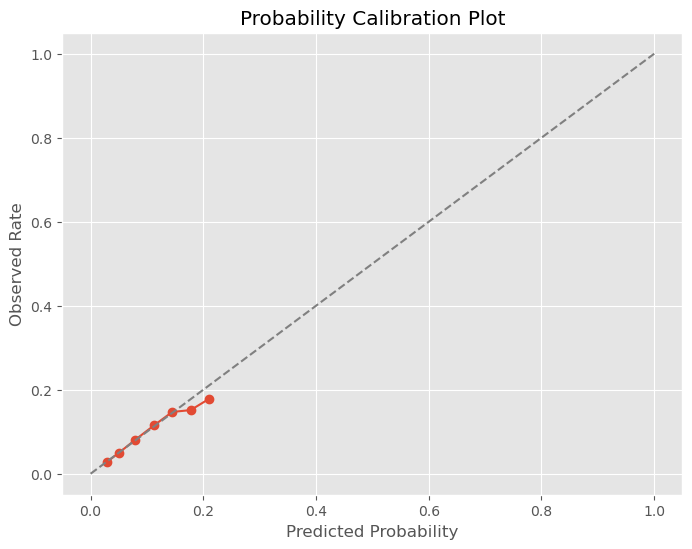

In [106]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid(True)
    plt.show()

plot_calibration(sack_attempts, proba_col='proba_sack', actual_col='was_sack', bins=30)

In [108]:
sack_attempts.sort_values(by='proba_sack', ascending=False).head()

,season,week,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,down,distance,pct_game_played,diff_time_ratio,is_home_team,grass,elevation,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,last12_offense_sacks_allowed_per_game,last12_offense_qb_hurries_allowed_per_game,last12_offense_sacks_allowed_per_game_gaussian,last12_offense_qb_hurries_allowed_per_game_gaussian,last12_defense_sacks_per_game,last12_defense_qb_hurries_per_game,last12_defense_sacks_per_game_gaussian,last12_defense_qb_hurries_per_game_gaussian,last6_offense_sacks_allowed_per_game,last6_offense_qb_hurries_allowed_per_game,last6_offense_sacks_allowed_per_game_gaussian,last6_offense_qb_hurries_allowed_per_game_gaussian,last6_defense_sacks_per_game,last6_defense_qb_hurries_per_game,last6_defense_sacks_per_game_gaussian,last6_defense_qb_hurries_per_game_gaussian,was_sack,sack_fumble,sack_yards_lost,sack_fumble_recovery_team,sack_fumble_recovery_yards,proba_sack,proba_bin
141414,2019,7,401112479104967901,40111247930,401112479,30,7,Florida State,Clemson,Pass Reception,james blackman pass complete to dj matthews f...,2.0,2.0,58,-38,3,13,0.944444,-1661.313673,-1,1,205.645218,2470.337324,3469.440902,-999.103578,83.3,5.8,0.000,3.92,3.42,3.306044,2.895935,5.04,3.58,4.459100,3.426276,4.67,3.50,3.731078,3.419100,6.0,2.67,5.138392,3.354078,0,0,NaN,nan,NaN,0.228023,6
277279,2022,2,401405078103964908,40140507822,401405078,22,4,Akron,Michigan State,Sack,jeff undercuffler jr sacked by derrick harmon...,3.0,0.0,79,-45,3,15,0.686111,-700.018620,-1,1,254.879486,1029.888833,2653.885752,-1623.996919,84.9,14.9,0.012,5.00,1.50,4.987285,1.521091,3.67,1.92,3.120130,2.507033,5.67,2.00,5.081733,1.916138,4.0,1.67,2.671583,2.038636,1,0,8.0,nan,NaN,0.227364,6
277270,2022,2,401405078104849916,40140507824,401405078,24,12,Akron,Michigan State,Pass Reception,jeff undercuffler jr pass complete to tj bank...,3.0,0.0,38,-52,3,17,0.750000,-1044.447920,-1,1,254.879486,1029.888833,2653.885752,-1623.996919,84.9,14.9,0.012,5.00,1.50,4.987285,1.521091,3.67,1.92,3.120130,2.507033,5.67,2.00,5.081733,1.916138,4.0,1.67,2.671583,2.038636,0,0,NaN,nan,NaN,0.227364,6
209909,2021,1,401281944104966002,40128194420,401281944,20,15,Akron,Auburn,Pass Reception,dj irons pass complete to michael mathison fo...,1.0,2.0,25,-46,3,15,0.939167,-1969.053133,-1,1,201.173798,941.155187,2866.727326,-1925.572139,70.0,0.0,0.000,5.25,2.58,5.069727,2.448254,2.17,2.67,1.922836,2.759263,4.33,1.83,4.872266,2.517981,3.0,3.33,2.507217,3.068445,0,0,NaN,nan,NaN,0.226227,6
209911,2021,1,401281944104885610,40128194420,401281944,20,6,Akron,Auburn,Pass Reception,dj irons pass complete to michael mathison fo...,2.0,3.0,58,-46,3,17,0.804722,-1150.015024,-1,1,201.173798,941.155187,2866.727326,-1925.572139,70.0,0.0,0.000,5.25,2.58,5.069727,2.448254,2.17,2.67,1.922836,2.759263,4.33,1.83,4.872266,2.517981,3.0,3.33,2.507217,3.068445,0,0,NaN,nan,NaN,0.226227,6


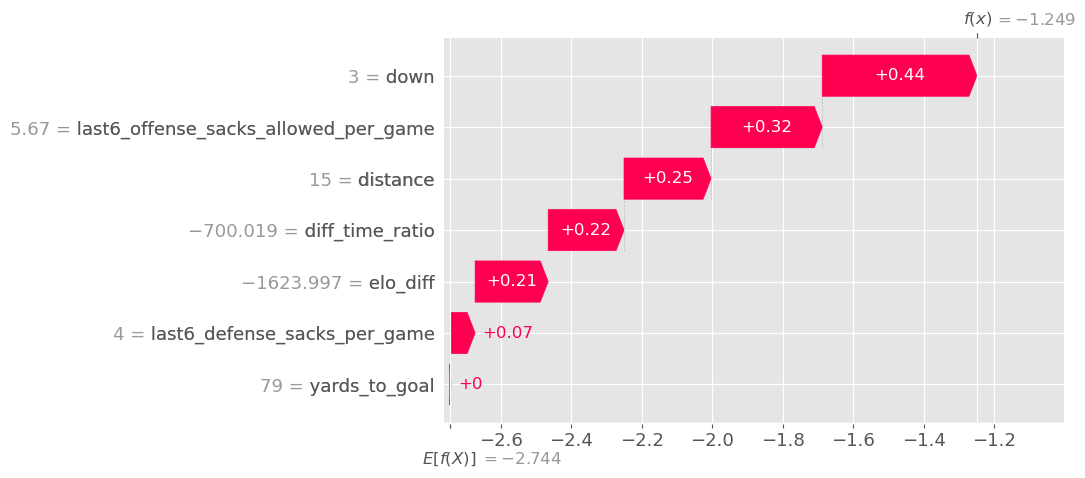

In [112]:
idx = 277279

game_data = sack_attempts.loc[sack_attempts.index == idx, feature_names].copy()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [113]:
model_dir = join('../models/raw', 'sack')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "sack_classifier_xgb.bin")
final_model.save_model(model_path)
print(f"Saved model to '{model_path}'")

Saved model to '../models/raw/sack/sack_classifier_xgb.bin'


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/2239126942.py:6: UserWarning: [15:44:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


# Model 2: Sack Turnover Model
Tried xgboost model, no real signal over dummy model. Will use baseline fumble rate of 8% for all sacks in simulation.

In [128]:
sack_attempts.query('was_sack == 1').sack_fumble.value_counts(normalize=True)

sack_fumble
0    0.92044
1    0.07956
Name: proportion, dtype: float64

# Model 3: Sack Fumble Recovery Team
Tried xgboost model with elo_diff as the only feature, failed to perform significantly over the dummy model. Using baseline rates of 53.5% offensive recovery rate.

In [152]:
sack_attempts.query('was_sack == 1 and sack_fumble == 1').sack_fumble_recovery_team.value_counts(normalize=True)

sack_fumble_recovery_team
offense    0.536159
defense    0.463841
Name: proportion, dtype: float64

# Model 4: Sack Fumble Yards Lost
No significant signal between features and sack yards lost. Will sample from the distrubtions of offensive and defensive recovery.

In [194]:
sack_attempts = (
    sack_attempts
    .assign(
        sack_fumble_yards_lost=lambda x: np.where(
            x.sack_fumble == 1,
            x.sack_yards_lost + x.sack_fumble_recovery_yards,
            np.nan
        ),
        sack_fumble_offense_recovery=lambda x: np.where(
            x.sack_fumble == 1,
            np.where(
                x.sack_fumble_recovery_team == 'offense',
                1, 0
            ),
            np.nan
        )
    )
)

In [195]:
sack_fumble = (
    sack_attempts.query('was_sack == 1 and sack_fumble == 1')
    .reset_index(drop=True)
    [['sack_yards_lost', 'sack_fumble_recovery_yards', 'sack_fumble_yards_lost', 'sack_fumble_recovery_team']]
)

In [196]:
sack_fumble.head()

,sack_yards_lost,sack_fumble_recovery_yards,sack_fumble_yards_lost,sack_fumble_recovery_team
0,11.0,0.0,11.0,offense
1,5.0,0.0,5.0,defense
2,8.0,0.0,8.0,offense
3,20.0,0.0,20.0,defense
4,1.0,0.0,1.0,offense


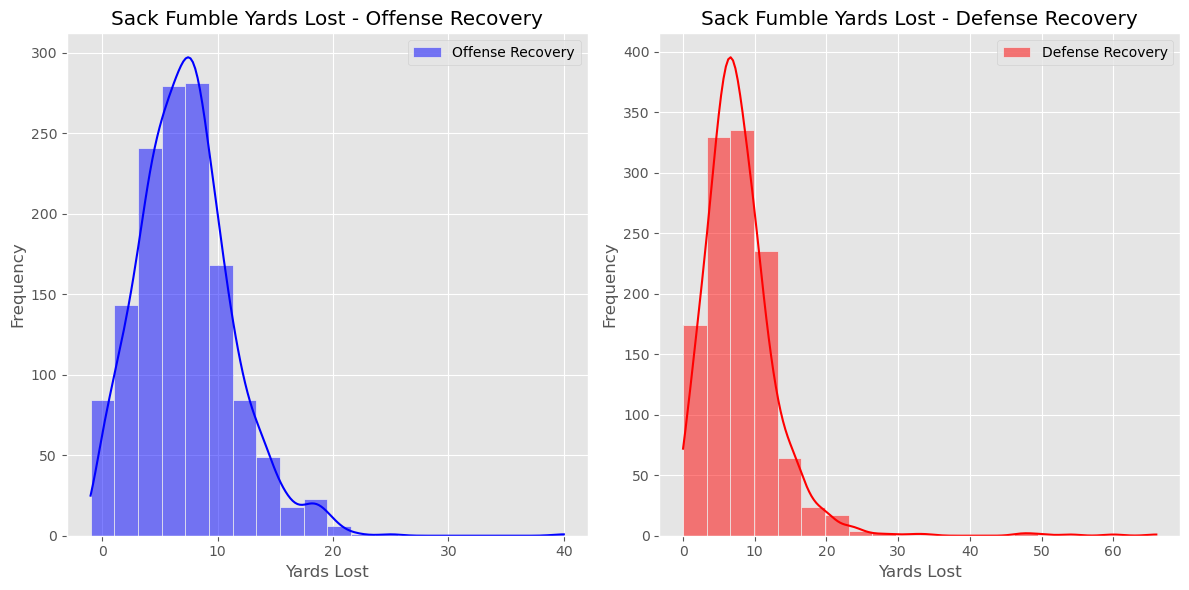

In [197]:
# plot two histograms side by side, for sack fumble yards lost by offense and defense
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(
    sack_fumble.query('sack_fumble_recovery_team == "offense"')['sack_fumble_yards_lost'],
    bins=20, kde=True, color='blue', label='Offense Recovery'
)
plt.title('Sack Fumble Yards Lost - Offense Recovery')
plt.xlabel('Yards Lost')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1, 2, 2)
sns.histplot(
    sack_fumble.query('sack_fumble_recovery_team == "defense"')['sack_fumble_yards_lost'],
    bins=20, kde=True, color='red', label='Defense Recovery'
)
plt.title('Sack Fumble Yards Lost - Defense Recovery')
plt.xlabel('Yards Lost')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [204]:
sack_fumble.query('sack_fumble_recovery_team == "offense"')['sack_fumble_yards_lost'].describe()

count    1379.000000
mean        7.319797
std         4.078686
min        -1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        40.000000
Name: sack_fumble_yards_lost, dtype: float64

In [210]:
n_offense = sack_attempts.query('sack_fumble_recovery_team == "offense"')
n_safety = sack_attempts.query('sack_fumble_recovery_team == "offense" and sack_fumble_yards_lost >= (100 - yards_to_goal)')
print(f"Number of offense recoveries: {len(n_offense)}")
print(f"Number of safeties: {len(n_safety)}")
print(f"Percentage of safeties: {len(n_safety) / len(n_offense) * 100:.2f}%")

Number of offense recoveries: 1379
Number of safeties: 15
Percentage of safeties: 1.09%


In [213]:
sack_attempts.query('sack_fumble_recovery_team == "offense" and sack_fumble_yards_lost >= (100 - yards_to_goal)').sack_yards_lost.describe()

count    15.000000
mean      9.333333
std       4.402380
min       3.000000
25%       6.500000
50%       9.000000
75%      11.000000
max      19.000000
Name: sack_yards_lost, dtype: float64

In [205]:
sack_fumble.query('sack_fumble_recovery_team == "defense"')['sack_fumble_yards_lost'].describe()

count    1193.000000
mean        7.994971
std         5.570022
min         0.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        66.000000
Name: sack_fumble_yards_lost, dtype: float64

In [211]:
n_defense = sack_attempts.query('sack_fumble_recovery_team == "defense"')
n_touchdown = sack_attempts.query('sack_fumble_recovery_team == "defense" and sack_fumble_yards_lost >= (100 - yards_to_goal)')
print(f"Number of defense recoveries: {len(n_defense)}")
print(f"Number of touchdowns: {len(n_touchdown)}")
print(f"Percentage of touchdowns: {len(n_touchdown) / len(n_defense) * 100:.2f}%")

Number of defense recoveries: 1193
Number of touchdowns: 21
Percentage of touchdowns: 1.76%


In [212]:
sack_attempts.query('sack_fumble_recovery_team == "defense" and sack_fumble_yards_lost >= (100 - yards_to_goal)').sack_yards_lost.describe()

count    21.000000
mean      7.857143
std       3.798496
min       2.000000
25%       5.000000
50%       7.000000
75%      11.000000
max      16.000000
Name: sack_yards_lost, dtype: float64

In [200]:
feature_names = [
    'yards_to_goal',
    # 'score_diff',
    'down',
    'distance',
    # 'pct_game_played',
    # 'diff_time_ratio',
    # 'is_home_team',
    # 'grass',
    # 'elevation',
    # 'offense_elo',
    # 'defense_elo',
    'elo_diff',
    # 'temperature',
    # 'wind_speed',
    # 'precipitation',
    # 'last12_offense_sacks_allowed_per_game',
    # 'last12_offense_qb_hurries_allowed_per_game',
    # 'last12_offense_sacks_allowed_per_game_gaussian',
    # 'last12_offense_qb_hurries_allowed_per_game_gaussian',
    # 'last12_defense_sacks_per_game',
    # 'last12_defense_qb_hurries_per_game',
    # 'last12_defense_sacks_per_game_gaussian',
    # 'last12_defense_qb_hurries_per_game_gaussian',
    # 'last6_offense_sacks_allowed_per_game',
    # 'last6_offense_qb_hurries_allowed_per_game',
    # 'last6_offense_sacks_allowed_per_game_gaussian',
    # 'last6_offense_qb_hurries_allowed_per_game_gaussian',
    # 'last6_defense_sacks_per_game',
    # 'last6_defense_qb_hurries_per_game',
    # 'last6_defense_sacks_per_game_gaussian',
    # 'last6_defense_qb_hurries_per_game_gaussian',
    'sack_fumble_offense_recovery'
    ]

target_variable = 'sack_fumble_yards_lost'

data = (
    sack_attempts.query('was_sack == 1 and sack_fumble == 1')
    [feature_names + [target_variable]].copy()
)

SEED = 2

binned_y = pd.qcut(data[target_variable], q=5, labels=False)

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=binned_y
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

binned_y_train = pd.qcut(train_data[target_variable], q=5, labels=False)

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify= binned_y_train
)

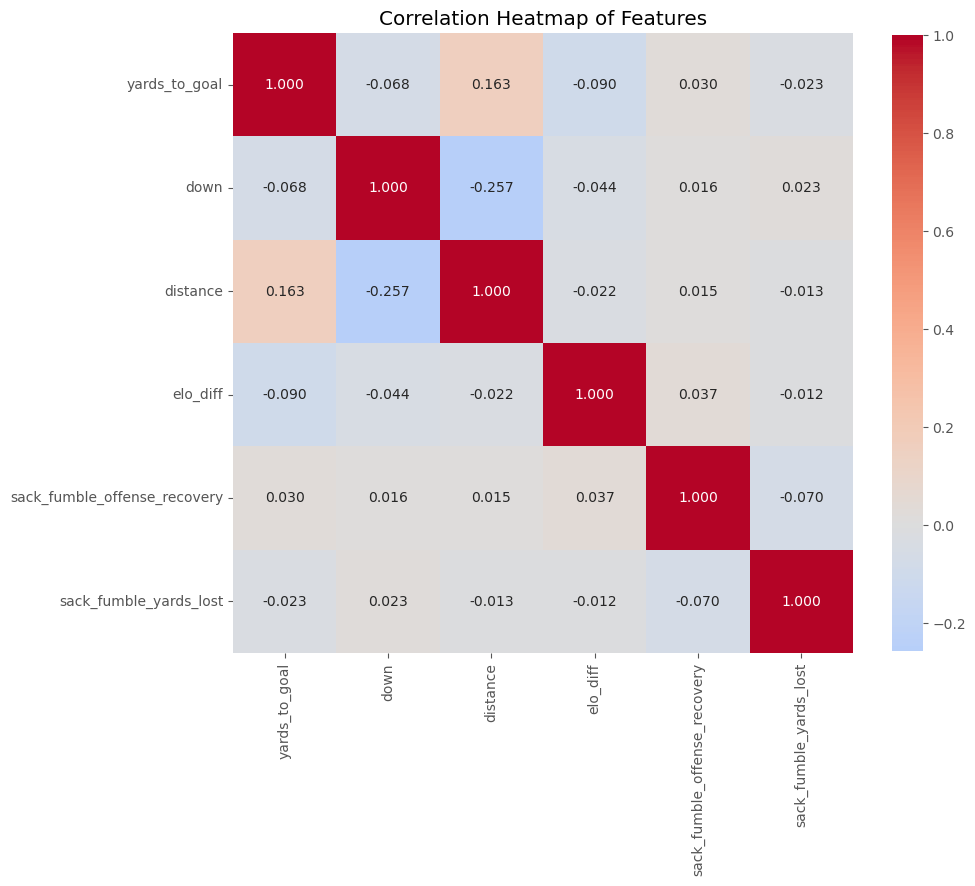

In [208]:
# correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    sack_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [201]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# monotonic_constraints_map = {
#     "yards_to_goal": -1,
#     "offense_elo": -1,
#     "defense_elo": 1,
# }
# monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Train models for different quantiles
# quantiles = [0.025, 0.5, 0.975]
quantiles = [0.5]
quantile_models = {}

for quantile in quantiles:
    # Objective function for Optuna tuning
    def objective(trial, dtrain, dvalid):
        param = {
            "nthread": -1,
            "objective": "reg:quantileerror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "quantile_alpha": quantile,
            # "monotone_constraints": monotonic_constraints,
            "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
            "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10, step=0.5),
            "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "seed": SEED,
        }

        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=500,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        preds = bst.predict(dvalid)
        return mean_absolute_error(valid_y, preds)

    # Run Optuna study
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(
        study_name=f"yards_gained_quantile_{quantile}",
        direction="minimize",
        load_if_exists=True,
        sampler=sampler
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50, show_progress_bar=True)

    # Train final model with best parameters
    best_params = {
        **study.best_trial.params,
        # 'monotone_constraints': monotonic_constraints,
        'nthread': -1,
        'objective': 'reg:quantileerror',
        'quantile_alpha': quantile,
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'seed': SEED,
    }

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    quantile_models[quantile] = final_model

# Make predictions for each quantile
for quantile in quantiles:
    sack_attempts[f'predicted_fumble_yards_lost{int(quantile*100)}'] = quantile_models[quantile].predict(
        xgb.DMatrix(sack_attempts[feature_names])
    )


from sklearn.metrics import mean_absolute_error, r2_score
# Helper to compute metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_pred = quantile_models[0.5].predict(dmatrix)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Mean Absolute Error : {mae:.4f}")
    print(f"R^2 Score           : {r2:.4f}") 

# Evaluate the median quantile model (0.5)
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)

  0%|          | 0/50 [00:00<?, ?it/s]


=== TRAIN SET METRICS ===
Mean Absolute Error : 2.9935
R^2 Score           : 0.0956

=== VALIDATION SET METRICS ===
Mean Absolute Error : 3.2174
R^2 Score           : -0.0033

=== TEST SET METRICS ===
Mean Absolute Error : 3.3626
R^2 Score           : -0.0338


In [202]:
# baseline model which predicts the mean yards gained
baseline_mean = train_y.median()
baseline_preds = np.full_like(valid_y, baseline_mean)  
baseline_mae = mean_absolute_error(valid_y, baseline_preds)
print(f"Baseline Mean MAE: {baseline_mae:.4f}")

Baseline Mean MAE: 3.2306


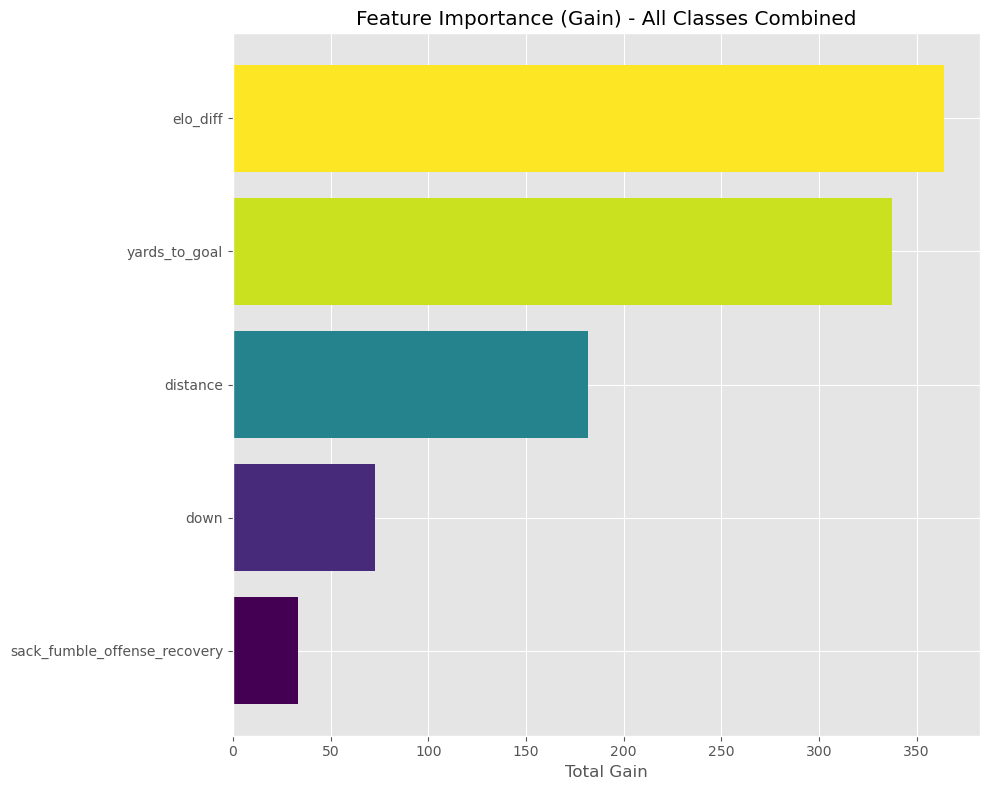

In [203]:
import matplotlib.cm as cm

trees_df = quantile_models[0.5].trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 25.88it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/2891584250.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


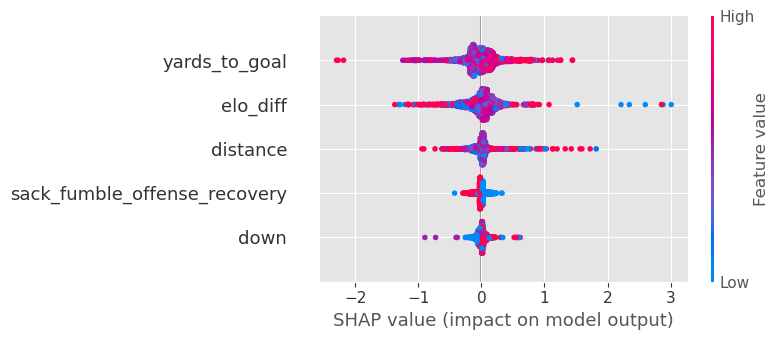

In [206]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(quantile_models[0.5])  # Use the median quantile model

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

In [280]:
# Save the empirical distribution of sack fumble yards lost for offense and defense

sack_fumble_yards_lost_offense = (
    sack_attempts
    .query('sack_fumble_recovery_team == "offense" and sack_fumble==1 and was_sack==1')
    .query('sack_fumble_yards_lost >= 0')
    [['sack_fumble_yards_lost']]
    .value_counts(normalize=True)
    .reset_index(name='proportion')
    .rename(columns={'sack_fumble_yards_lost': 'yards_lost'})
    .sort_values(by='yards_lost', ascending=True, ignore_index=True)
)
sack_fumble_yards_lost_defense = (
    sack_attempts
    .query('sack_fumble_recovery_team == "defense" and sack_fumble==1 and was_sack==1')
    [['sack_fumble_yards_lost']]
    .value_counts(normalize=True)
    .reset_index(name='proportion')
    .rename(columns={'sack_fumble_yards_lost': 'yards_lost'})
    .sort_values(by='yards_lost', ascending=True, ignore_index=True)
)

model_dir = join('../models/raw', 'sack')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

sack_fumble_yards_lost_offense.to_parquet(
    join(model_dir, 'sack_fumble_yards_lost_offense.parquet'),
    index=False
)
sack_fumble_yards_lost_defense.to_parquet(
    join(model_dir, 'sack_fumble_yards_lost_defense.parquet'),
    index=False
)

In [281]:
sack_fumble_yards_lost_offense

,yards_lost,proportion
0,0.0,0.028302
1,1.0,0.031930
2,2.0,0.047896
3,3.0,0.055878
4,4.0,0.084180
5,5.0,0.090711
6,6.0,0.098694
7,7.0,0.103774
8,8.0,0.116836
9,9.0,0.087083


In [230]:
sack_fumble_yards_lost_defense

,yards_lost,proportion
0,0.0,0.020956
1,1.0,0.022632
2,2.0,0.056161
3,3.0,0.046102
4,4.0,0.077117
5,5.0,0.091366
6,6.0,0.108131
7,7.0,0.116513
8,8.0,0.090528
9,9.0,0.073764


# Model 5: Sack Yards Lost Model
XGBoost had same MAE as baseline model that predicts median sack yards lost. Will sample from historical distribution instead. 

In [155]:
sack_attempts.query('was_sack == 1 and sack_fumble == 0').sack_yards_lost.describe()

count    29756.000000
mean         6.060358
std          3.382925
min          0.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         20.000000
Name: sack_yards_lost, dtype: float64

In [158]:
feature_names = [
    'yards_to_goal',
    # 'score_diff',
    'down',
    'distance',
    # 'pct_game_played',
    'diff_time_ratio',
    # 'is_home_team',
    # 'grass',
    # 'elevation',
    # 'offense_elo',
    # 'defense_elo',
    'elo_diff',
    # 'temperature',
    # 'wind_speed',
    # 'precipitation',
    # 'last12_offense_sacks_allowed_per_game',
    # 'last12_offense_qb_hurries_allowed_per_game',
    # 'last12_offense_sacks_allowed_per_game_gaussian',
    # 'last12_offense_qb_hurries_allowed_per_game_gaussian',
    # 'last12_defense_sacks_per_game',
    # 'last12_defense_qb_hurries_per_game',
    # 'last12_defense_sacks_per_game_gaussian',
    # 'last12_defense_qb_hurries_per_game_gaussian',
    # 'last6_offense_sacks_allowed_per_game',
    # 'last6_offense_qb_hurries_allowed_per_game',
    # 'last6_offense_sacks_allowed_per_game_gaussian',
    # 'last6_offense_qb_hurries_allowed_per_game_gaussian',
    # 'last6_defense_sacks_per_game',
    # 'last6_defense_qb_hurries_per_game',
    # 'last6_defense_sacks_per_game_gaussian',
    # 'last6_defense_qb_hurries_per_game_gaussian',
]
target_variable = 'sack_yards_lost'

data = sack_attempts.query('was_sack == 1 and sack_fumble == 0')[feature_names + [target_variable]].copy()

SEED = 22
np.random.seed(SEED)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], train_data[target_variable], 
    test_size=0.2, random_state=SEED
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# monotonic_constraints_map = {
#     "yards_to_goal": -1,
#     "offense_elo": -1,
#     "defense_elo": 1,
# }
# monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Train models for different quantiles
quantiles = [0.025, 0.5, 0.975]
quantile_models = {}

for quantile in quantiles:
    # Objective function for Optuna tuning
    def objective(trial, dtrain, dvalid):
        param = {
            "nthread": -1,
            "objective": "reg:quantileerror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "quantile_alpha": quantile,
            # "monotone_constraints": monotonic_constraints,
            "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
            "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10, step=0.5),
            "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "seed": SEED,
        }

        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=500,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        preds = bst.predict(dvalid)
        return mean_absolute_error(valid_y, preds)

    # Run Optuna study
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(
        study_name=f"sack_yards_lost_quantile_{quantile}",
        direction="minimize",
        load_if_exists=True,
        sampler=sampler
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=10, show_progress_bar=True)

    # Train final model with best parameters
    best_params = {
        **study.best_trial.params,
        # 'monotone_constraints': monotonic_constraints,
        'nthread': -1,
        'objective': 'reg:quantileerror',
        'quantile_alpha': quantile,
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'seed': SEED,
    }

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    quantile_models[quantile] = final_model

# Make predictions for each quantile
for quantile in quantiles:
    sack_attempts[f'predicted_sack_yards_lost_{int(quantile*100)}'] = quantile_models[quantile].predict(
        xgb.DMatrix(sack_attempts[feature_names])
    )


from sklearn.metrics import mean_absolute_error, r2_score
# Helper to compute metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_pred = quantile_models[0.5].predict(dmatrix)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Mean Absolute Error : {mae:.4f}")
    print(f"R^2 Score           : {r2:.4f}") 

# Evaluate the median quantile model (0.5)
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


=== TRAIN SET METRICS ===
Mean Absolute Error : 2.7003
R^2 Score           : 0.0167

=== VALIDATION SET METRICS ===
Mean Absolute Error : 2.6990
R^2 Score           : 0.0108

=== TEST SET METRICS ===
Mean Absolute Error : 2.6527
R^2 Score           : 0.0112


In [159]:
# baseline model which predicts the mean yards gained
baseline_mean = train_y.median()
baseline_preds = np.full_like(valid_y, baseline_mean)  
baseline_mae = mean_absolute_error(valid_y, baseline_preds)
print(f"Baseline Mean MAE: {baseline_mae:.4f}")

Baseline Mean MAE: 2.7072


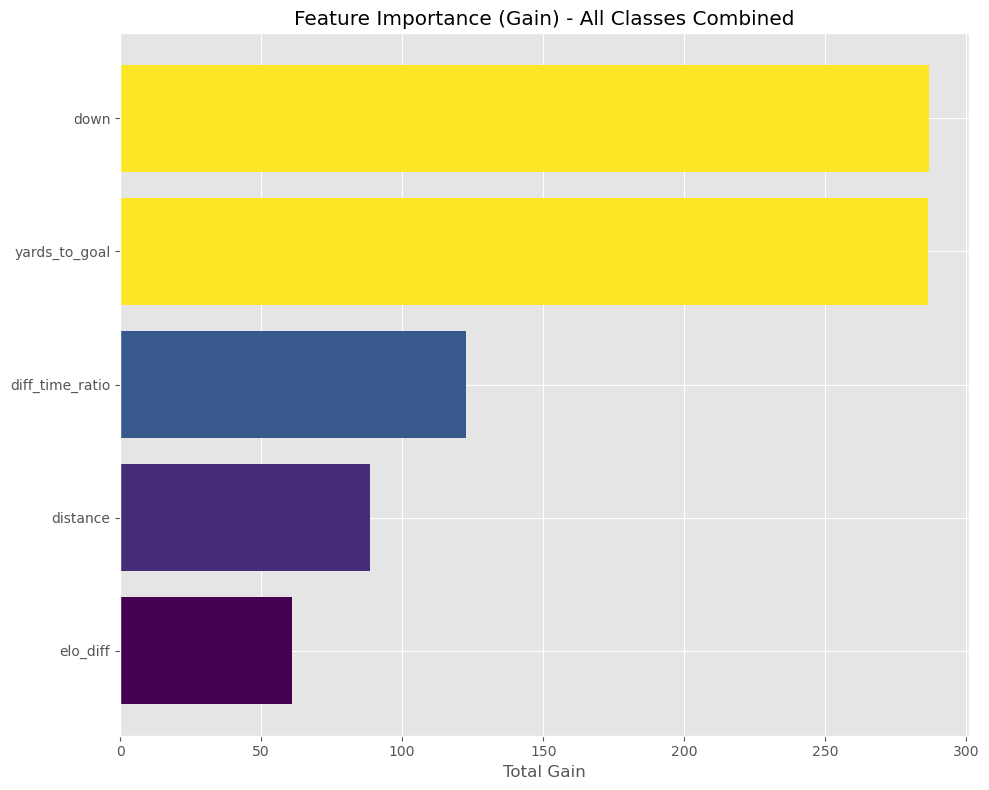

In [160]:
import matplotlib.cm as cm

trees_df = quantile_models[0.5].trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 3/3 [00:00<00:00, 31.44it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_89297/2891584250.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


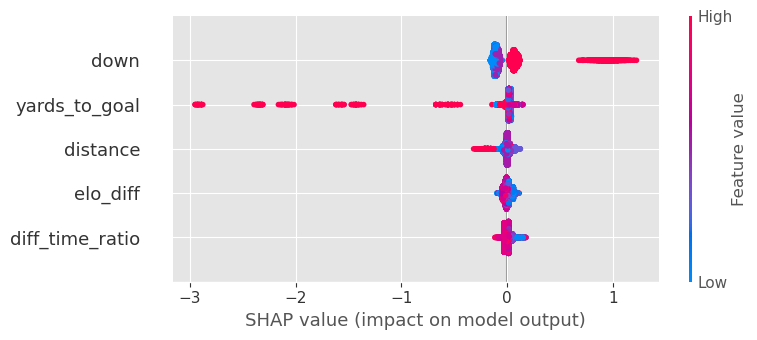

In [161]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(quantile_models[0.5])  # Use the median quantile model

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

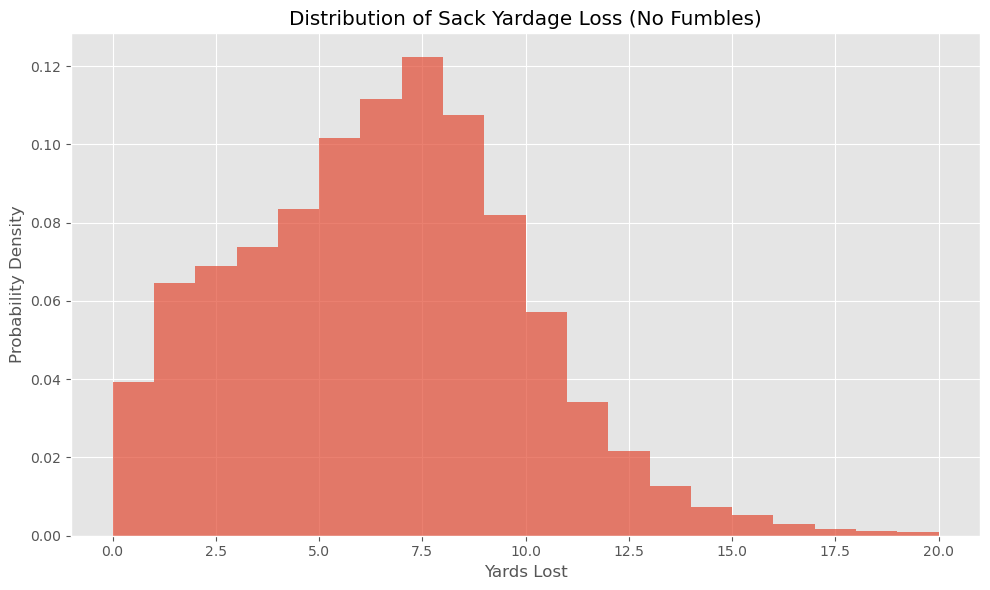

In [ ]:
qry = sack_attempts.query('was_sack == 1 and sack_fumble == 0').sack_yards_lost
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.hist(qry, bins=20, density=True, alpha=0.7)
plt.title('Distribution of Sack Yardage Loss (No Fumbles)')
plt.xlabel('Yards Lost')
plt.ylabel('Probability Density')
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
# save the precentages at each yardage lost value
yardage_loss_percentages = (
    sack_attempts.query('was_sack == 1 and sack_fumble == 0')
    .sack_yards_lost.value_counts(normalize=True)
    .sort_index()
    .reset_index()
)
yardage_loss_percentages.columns = ['yards_lost', 'percentage']
yardage_loss_percentages

,yards_lost,percentage
0,0.0,0.039320
1,1.0,0.064525
2,2.0,0.068961
3,3.0,0.073666
4,4.0,0.083546
5,5.0,0.101526
6,6.0,0.111574
7,7.0,0.122261
8,8.0,0.107541
9,9.0,0.081866


In [179]:
model_dir = join('../models/raw', 'sack')
yardage_loss_percentages.to_parquet(
    join(model_dir, 'sack_yardage_loss_percentages.parquet'),
    index=False,
    engine='pyarrow'
)

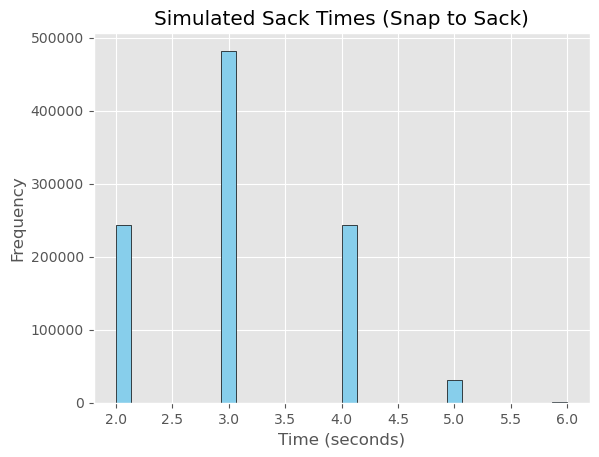

In [246]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# Define parameters
lower_bound = 2.0  # minimum plausible sack time
upper_bound = 7.0  # maximum plausible sack time
mean = 3.5         # average sack time
std_dev = 0.8      # standard deviation

# Convert to truncated normal parameters
a, b = (lower_bound - mean) / std_dev, (upper_bound - mean) / std_dev

# Create truncated normal distribution
sack_time_dist = truncnorm(a, b, loc=mean, scale=std_dev)

# Sample 1000 sack times
samples = sack_time_dist.rvs(1000000).astype(int)

# Optional: Visualize
plt.hist(samples, bins=30, color='skyblue', edgecolor='black')
plt.title("Simulated Sack Times (Snap to Sack)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()